Import Libraries

In [1]:
import jax
import flax
import optax
from jax import lax, random, numpy as jnp
from jax import random, grad, vmap, hessian, jacfwd, jit
from jax import config
from flax import linen as nn
!pip install evojax
from evojax.util import get_params_format_fn

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# choose GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
jax.config.update("jax_enable_x64", True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.1/96.1 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.7/269.7 kB 10.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')
input_dir = "/content/drive/My Drive/DNN + Helmholtz/"

Mounted at /content/drive


Problem: 2D Helmholtz Equation

        (u_xx + u_yy) + k**2 * u = g

In [3]:
# Function to generate analytical solution
@jit
def eval_u(x, y, a1, a2):
    u = jnp.sin(a1*jnp.pi*x) * jnp.sin(a2*jnp.pi*y)
    return u

# obtain g
@jit
def eval_g(x, y, a1, a2):
    g = (k**2 - (a1*jnp.pi)**2 - (a2*jnp.pi)**2) * jnp.sin(a1*jnp.pi*x) * jnp.sin(a2*jnp.pi*y)
    return g

x_l, x_u = -1, 1
y_l, y_u = -1, 1

# PDE parameters
k = 1
a1, a2 = jnp.meshgrid(jnp.linspace(0, 6, 11)[1:], jnp.linspace(0, 6, 11)[1:])
a1, a2 = a1.reshape(-1, 1), a2.reshape(-1, 1)
task_params = jnp.hstack([a1, a2])
n_task = len(task_params)
print (n_task)
# a1 ∈ (0, 6] and a2 ∈ (0, 6]

100


In [4]:
# sample (64x64)
xs = jnp.linspace(-1, 1, 64)
ys = jnp.linspace(-1, 1, 64)
x, y = jnp.meshgrid(xs, ys)
x, y = x.reshape(-1, 1), y.reshape(-1, 1)
inputs = jnp.hstack([x, y])

#### Noiseless source function: analytical

k = 1.0, a1 = 1.2, a2 = 5.4


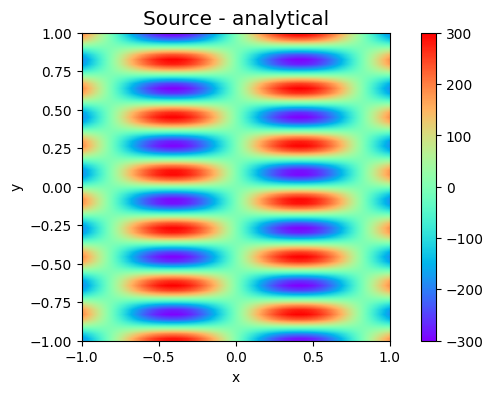

In [5]:
## example (noiseless source function: eval_g)
task = 81

#ground truth: a1 = 1.2, a2 = 5.4
a1, a2 = task_params[task]
g = eval_g(x, y, a1, a2)
print ('k = %.1f, a1 = %.1f, a2 = %.1f'%(k, a1, a2))

# plot
fig = plt.figure(figsize=(8, 4))
ext = [x_l, x_u, y_l, y_u]     # plot boundary
u_plot = g.reshape(64, -1)
mesh2 = plt.imshow(u_plot, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=1.);
plt.colorbar(mesh2);
plt.xlabel('x'); plt.ylabel('y');
plt.title('Source - analytical', fontsize='x-large');

#### Noisy data (inverse inference DNN)

In [6]:
class DNN(nn.Module):
    """DNN"""
    def setup(self):
        self.layers = [nn.Dense(n_nodes, kernel_init = jax.nn.initializers.he_uniform()),
                       jnp.sin]
        self.last_layer = nn.Dense(1, kernel_init = jax.nn.initializers.he_uniform(), use_bias=False)

    @nn.compact
    def __call__(self, inputs):
        # split the two variables, probably just by slicing
        x, y = inputs[:,0:1], inputs[:,1:2]
        def get_u(x, y):
            f = jnp.hstack([x, y])
            for i, lyr in enumerate(self.layers):
                f = lyr(f)
                if (i == 0):
                    f = 4 *jnp.pi *f
            u = self.last_layer(f)
            return u

        u = get_u(x, y)

        outputs = u
        return outputs

In [7]:
# choose seed
seed = 8
key, rng = random.split(random.PRNGKey(seed))

# dummy input
a = random.normal(key, [1,2])

# initialization call
n_nodes = 1024
model_inv = DNN()
params_inv = model_inv.init(key, a)
num_params_inv, format_params_fn_inv = get_params_format_fn(params_inv)

# load weigths
params_inv = jnp.load(input_dir + 'InverseDNN_weights.npy')

In [8]:
# noisy source function
g_inv = model_inv.apply(format_params_fn_inv(params_inv), inputs) #use this data for symbolic regression?
#inputs from -1 to 1 (print inputs)

mse = jnp.mean(jnp.square(g_inv - g))
rl2 = jnp.linalg.norm(g_inv - g) / jnp.linalg.norm(g)
print ('Inference source mse = %.3f,  rl2 = %.3f'%(mse, rl2))

Inference source mse = 14.433,  rl2 = 0.027


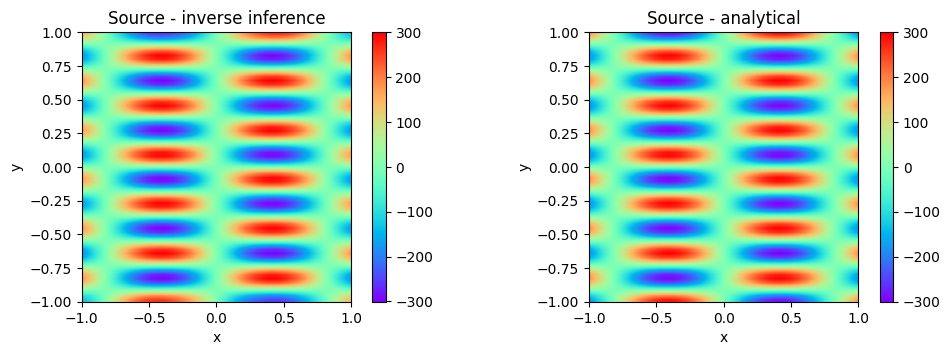

In [9]:
# plot
fig = plt.figure(figsize=(12, 3.5))
ax1 = fig.add_subplot(1,2,1)
u_plot = g_inv.reshape(64, -1)
mesh2 = plt.imshow(u_plot, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=1.);
plt.colorbar(mesh2);
plt.xlabel('x'); plt.ylabel('y'); plt.title('Source - inverse inference', fontsize='large');
ax1 = fig.add_subplot(1,2,2)
u_plot = g.reshape(64, -1)
mesh2 = plt.imshow(u_plot, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=1.);
plt.colorbar(mesh2);
plt.xlabel('x'); plt.ylabel('y'); plt.title('Source - analytical', fontsize='large');

# GP Learn

In [ ]:
#Verify working directory
input_path = '/content/drive/My Drive/DNN + Helmholtz/'
os.chdir(input_path)
!pwd

/content/drive/My Drive/DNN + Helmholtz


In [ ]:
#check how inputs (x, y) look like
inputs

Array([[-1.        , -1.        ],
       [-0.96825397, -1.        ],
       [-0.93650794, -1.        ],
       ...,
       [ 0.93650794,  1.        ],
       [ 0.96825397,  1.        ],
       [ 1.        ,  1.        ]], dtype=float64)

In [ ]:
#Create data
data = jnp.hstack([inputs, g_inv])
data.shape

(4096, 3)

In [ ]:
# Saving data as a .txt file in working directory for use by symbolic regression function
np.save(input_path + 'helmholtz_data.npy', data)
np.savetxt(input_path + 'helmholtz_data.txt',data,delimiter=' ')

# Printing out generated data with Pandas and plotting it with matplotlib
df=pd.read_csv(input_path + 'helmholtz_data.txt',sep=" ",header=None)
data = df.to_numpy()
print(data.shape) #can also load txt file this way - going to just use generated file from before

(4096, 3)


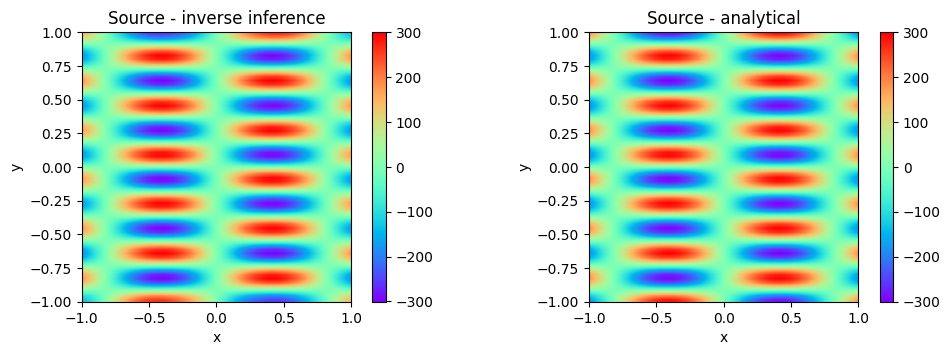

In [ ]:
#verify with a plot

fig = plt.figure(figsize=(12, 3.5))
ax1 = fig.add_subplot(1,2,1)
u_plot = data[:,2].reshape(64, -1)
mesh2 = plt.imshow(u_plot, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=1.);
plt.colorbar(mesh2);
plt.xlabel('x'); plt.ylabel('y'); plt.title('Source - inverse inference', fontsize='large');
ax1 = fig.add_subplot(1,2,2)
u_plot = g.reshape(64, -1)
mesh2 = plt.imshow(u_plot, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=1.);
plt.colorbar(mesh2);
plt.xlabel('x'); plt.ylabel('y'); plt.title('Source - analytical', fontsize='large');

GP learn

In [ ]:
# Installing gplearn
# https://gplearn.readthedocs.io/en/stable/installation.html
!pip install gplearn

In [ ]:
%pylab inline
from gplearn.genetic import SymbolicRegressor

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['seed', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [ ]:
function_set = ['add', 'sub', 'mul', 'div',
                'sqrt', 'log', 'abs', 'neg', 'inv',
                'max', 'min', 'sin', 'cos', 'tan']

# Running gplearn symbolic regression on perfect data (default settings)
est_gp = SymbolicRegressor(population_size=1000,
                           generations=100, stopping_criteria=0.001,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0, function_set=function_set)
est_gp.fit(data[:,:2], data[:,2:3])
print(est_gp._program)

# The smaller the dataset, population_size can be increased. If the known target equation is (relatively) simple, parsimony_coefficient can be increased.
# https://github.com/trevorstephens/gplearn/blob/master/gplearn/genetic.py

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    12.61          111.854        6          109.018          123.166      5.50m
   1     8.19          110.855        4           109.01          123.204      2.04m
   2     7.11          110.533        3          109.141          122.163      1.94m
   3     5.97          110.516        9          109.012          123.359      1.81m
   4     5.33          110.474        7          109.087          122.881      1.97m
   5     4.66          110.501        1          109.186          121.673      2.71m
   6     4.14          110.467        3          109.119          122.345      2.65m
   7     3.75          110.434        4          109.011          123.233      2.24m
   8     3.51          110.459        3          109.039           122.98  

Plotting Result Functions

In [12]:
def eval_sr(x0, x1):
   # u = ((1 + 0) + 0.293) - (x0/x1)
    u = (jnp.cos(jnp.log(-0.380+x0)))/x1
    return u

In [13]:
# sample (64x64)
xs = jnp.linspace(-1, 1, 64)
ys = jnp.linspace(-1, 1, 64)
x, y = jnp.meshgrid(xs, ys)
x, y = x.reshape(-1, 1), y.reshape(-1, 1)
inputs = jnp.hstack([x, y])
x_l, x_u = -1, 1
y_l, y_u = -1, 1
ext = [x_l, x_u, y_l, y_u]

soln = eval_sr(x, y) #inputs from earlier, should yield shape of (4096, 1)
soln.shape, soln

((4096, 1),
 Array([[       nan],
        [       nan],
        [       nan],
        ...,
        [0.83311863],
        [0.86250536],
        [0.88790024]], dtype=float64))

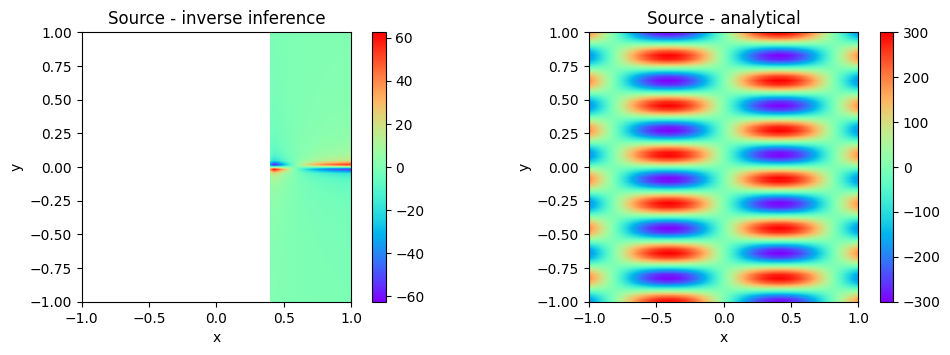

In [14]:
fig = plt.figure(figsize=(12, 3.5))
ax1 = fig.add_subplot(1,2,1)
u_plot = soln[:,2].reshape(64, -1)
mesh2 = plt.imshow(u_plot, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=1.);
plt.colorbar(mesh2);
plt.xlabel('x'); plt.ylabel('y'); plt.title('Source - inverse inference', fontsize='large');
ax1 = fig.add_subplot(1,2,2)
u_plot = g.reshape(64, -1)
mesh2 = plt.imshow(u_plot, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=1.);
plt.colorbar(mesh2);
plt.xlabel('x'); plt.ylabel('y'); plt.title('Source - analytical', fontsize='large');